In [1]:
import torch
import keras
from sklearn.model_selection import train_test_split

In [2]:
# IMDB 데이터셋
(train_input, train_target), (test_input, test_target) = keras.datasets.imdb.load_data(num_words=500)

# 훈련세트, 검증 세트
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42
)

In [3]:
# 패딩 처리
from keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [4]:
train_seq = torch.tensor(train_seq)
val_seq = torch.tensor(val_seq)
train_target = torch.tensor(train_target, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)

In [5]:
# TensorDataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_seq, train_target)
val_dataset = TensorDataset(val_seq, val_target)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [7]:
# 층 구성
import torch.nn as nn

class IMDBLstm(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(500, 16)
        self.lstm = nn.LSTM(16, 8, num_layers=2, dropout=0.2, batch_first=True)
        self.dense = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        outputs = self. dense(hidden[-1])

        return self.sigmoid(outputs)


In [9]:
from torchinfo import summary
model = IMDBLstm()
summary(model)

Layer (type:depth-idx)                   Param #
IMDBLstm                                 --
├─Embedding: 1-1                         8,000
├─LSTM: 1-2                              1,408
├─Linear: 1-3                            9
├─Sigmoid: 1-4                           --
Total params: 9,417
Trainable params: 9,417
Non-trainable params: 0

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

IMDBLstm(
  (embedding): Embedding(500, 16)
  (lstm): LSTM(16, 8, num_layers=2, batch_first=True, dropout=0.2)
  (dense): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [11]:
# 옵티마이저, 손실함수 
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [12]:
train_hist = []
val_hist = []
patience= 2
best_loss = -1
early_stopping_counter = 0

epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    
    train_hist.append(train_loss)
    val_hist.append(val_loss)

    print(f"에포크:{epoch+1}, 훈련손실:{train_loss:.4f}, 검증손실:{val_loss:.4f}")

    if best_loss == -1 or val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_lstm_model.pt')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"{epoch+1}번째에서 조기 중단..")
            break

에포크:1, 훈련손실:0.6889, 검증손실:0.6688
에포크:2, 훈련손실:0.6279, 검증손실:0.6134
에포크:3, 훈련손실:0.5771, 검증손실:0.5633
에포크:4, 훈련손실:0.5477, 검증손실:0.5395
에포크:5, 훈련손실:0.5397, 검증손실:0.5519
에포크:6, 훈련손실:0.5165, 검증손실:0.5323
에포크:7, 훈련손실:0.4947, 검증손실:0.5173
에포크:8, 훈련손실:0.5060, 검증손실:0.5101
에포크:9, 훈련손실:0.4807, 검증손실:0.5036
에포크:10, 훈련손실:0.4861, 검증손실:0.5051
에포크:11, 훈련손실:0.4796, 검증손실:0.4984
에포크:12, 훈련손실:0.4573, 검증손실:0.5063
에포크:13, 훈련손실:0.4617, 검증손실:0.4869
에포크:14, 훈련손실:0.4537, 검증손실:0.4914
에포크:15, 훈련손실:0.4733, 검증손실:0.4939
15번째에서 조기 중단..


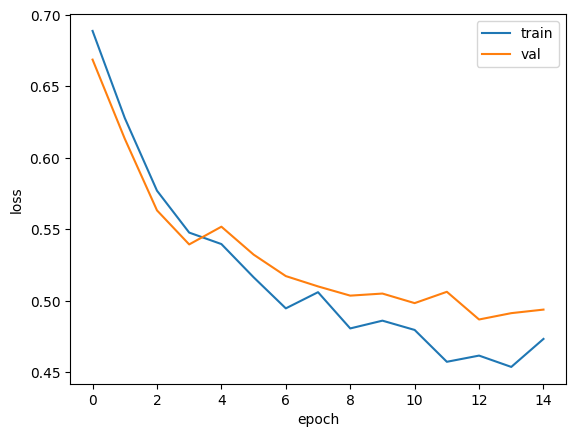

In [13]:
import matplotlib.pyplot as plt

plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [14]:
model.eval()
corrects = 0
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predicts = outputs.squeeze() > 0.5
        corrects += (predicts == targets).sum().item()

accuracy = corrects / len(val_dataset)
print(f"검증 정확도:{accuracy:.4f}")

검증 정확도:0.7624
